In [11]:
# GPU: w Colab wybierz Runtime → Change runtime type → GPU (T4/L4)

!pip install -q "torch>=2.3" "accelerate>=0.34" "transformers>=4.43" sentence-transformers chromadb
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q pillow pdf2image
!sudo apt-get -y install poppler-utils  # dla pdf2image (opcjonalnie)
!pip install -U bitsandbytes


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


getNodeByIdOrMessageId - no node found by id: placeholder-request-68d2ec58-529c-8329-ac34-d4036dd9a0f1-1

In [5]:
import hashlib

def sha256_of_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def text_id_from_content(content: str) -> str:
    return "text::" + hashlib.sha256(content.encode("utf-8")).hexdigest()

def image_id_from_path(path: str) -> str:
    # ID po zawartości pliku (nie po nazwie), więc ten sam obraz nie doda się drugi raz
    return "image::" + sha256_of_file(path)

def add_unique(collection, ids, embeddings, documents, metadatas) -> int:
    """Dodaj tylko te rekordy, których ID jeszcze nie ma w kolekcji."""
    if not ids:
        return 0
    # pobierz istniejące (po samych ID)
    existing_ids = set(collection.get(ids=ids)["ids"])
    add_idx = [i for i,_id in enumerate(ids) if _id not in existing_ids]
    if add_idx:
        collection.add(
            ids=[ids[i] for i in add_idx],
            embeddings=[embeddings[i] for i in add_idx],
            documents=[documents[i] for i in add_idx],
            metadatas=[metadatas[i] for i in add_idx],
        )
    return len(add_idx)


In [6]:
# ====== Imports & setup ======
import os, glob, json, torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
from transformers import AutoProcessor, AutoModelForCausalLM
from pathlib import Path  # << PATCH: będziemy filtrować pliki po rozszerzeniach

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


# Ścieżki na dane
BASE = "/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data"
IMG_DIR = f"{BASE}/images/train"
TXT_DIR = f"{BASE}/texts"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(TXT_DIR, exist_ok=True)

# ====== Dane przykładowe (wrzuć swoje pliki do /content/data/images oraz /content/data/texts) ======
# jeśli nie masz obrazów, stworzymy jeden testowy "syntetyczny"
img_path = f"{IMG_DIR}/cat.jpg"
if not os.path.exists(img_path):
    img = Image.new("RGB", (512, 384), (230, 240, 255))
    d = ImageDraw.Draw(img)
    d.text((20, 20), "Photo of a white cat on green grass", fill=(10, 20, 60))
    img.save(img_path)

# jeśli nie masz tekstów, stworzymy dwa pliki
txt1 = f"{TXT_DIR}/faq_1.txt"
txt2 = f"{TXT_DIR}/faq_2.txt"
if not os.path.exists(txt1):
    with open(txt1, "w") as f:
        f.write("Kot domowy to gatunek ssaka drapieżnego z rodziny kotowatych. Lubi trawę i słońce.")
if not os.path.exists(txt2):
    with open(txt2, "w") as f:
        f.write("Qwen-VL to model Vision-Language, który potrafi łączyć obraz i tekst w odpowiedziach.")

# ====== Modele embeddingów ======
# Tekst: lekki, szybki
text_embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=DEVICE)
# Obraz: CLIP (wersja sentence-transformers; potrafi encode() na obrazach PIL)
image_embedder = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

def embed_texts(texts):
    vecs = text_embedder.encode(texts, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)
    return vecs

# ====== PATCH: bezpieczne wczytywanie obrazów + filtr rozszerzeń ======
IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".gif"}

def embed_images(paths):
    loaded_images = []
    kept_paths = []
    for p in paths:
        try:
            with Image.open(p) as im:
                loaded_images.append(im.convert("RGB").copy())
                kept_paths.append(p)
        except Exception as e:
            # Nie przerywaj — pomiń plik, który nie jest obrazem (np. _annotations.coco.json)
            print(f"[pomijam] {p}: {e}")

    if not loaded_images:
        dim = image_embedder.get_sentence_embedding_dimension()
        return np.zeros((0, dim)), []

    vecs = image_embedder.encode(
        loaded_images,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )
    return vecs, kept_paths
# ====== /PATCH ======


# ====== Budowa wektorówek (dwie kolekcje) ======
PERSIST_DIR = f"{BASE}/chroma"
client = chromadb.PersistentClient(path=PERSIST_DIR)

#client = chromadb.Client(Settings(anonymized_telemetry=False))
col_text  = client.get_or_create_collection(name="mmrag_text",  metadata={"hnsw:space": "cosine","dim":384,"embedder":"all-MiniLM-L6-v2"})
col_image = client.get_or_create_collection(name="mmrag_image", metadata={"hnsw:space": "cosine","dim":512,"embedder":"clip-ViT-B-32"})

# --- ŚCIEŻKI DANYCH (tuż po utworzeniu col_text/col_image) ---
IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".gif"}
image_paths = [str(p) for p in Path(IMG_DIR).rglob("*") if p.suffix.lower() in IMG_EXTS]
text_paths  = [str(p) for p in Path(TXT_DIR).glob("*.txt")]

print(f"Znaleziono {len(image_paths)} obrazów i {len(text_paths)} tekstów")

# --- Dodaj TEXT (dedup + unikamy re-embedowania) ---
text_items = []  # (id, content, path)
for p in text_paths:
    with open(p, "r", encoding="utf-8") as f:
        content = f.read()
    tid = text_id_from_content(content)  # stabilne ID po treści
    text_items.append((tid, content, p))

# Sprawdź, które ID już są w kolekcji
to_check_ids = [tid for tid,_,_ in text_items]
existing = set(col_text.get(ids=to_check_ids)["ids"]) if to_check_ids else set()

# Zostaw tylko nowe do embedowania i dodania
new_items = [(tid, content, p) for (tid, content, p) in text_items if tid not in existing]

if new_items:
    new_docs = [c for _,c,_ in new_items]
    new_ids  = [i for i,_,_ in new_items]
    new_meta = [{"type":"text", "path": p} for _,_,p in new_items]

    txt_vecs = text_embedder.encode(new_docs, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)
    added = add_unique(col_text, new_ids, txt_vecs.tolist(), new_docs, new_meta)
    print(f"[TEXT] Dodano: {added}, pominięto (duplikaty): {len(new_items)-added}")
else:
    print("[TEXT] Brak nowych dokumentów do dodania.")


# --- Dodaj IMAGE ---
# --- Dodaj IMAGE (dedup + unikamy re-embedowania) ---
# Najpierw nadajemy ID po zawartości pliku, zanim zaczniemy embedować
img_items = []  # (id, path)
for p in image_paths:
    try:
        iid = image_id_from_path(p)  # sha256 pliku
        img_items.append((iid, p))
    except Exception as e:
        print(f"[pomijam-hash] {p}: {e}")

to_check_img_ids = [iid for iid,_ in img_items]
existing_img = set(col_image.get(ids=to_check_img_ids)["ids"]) if to_check_img_ids else set()

new_img_paths = [p for (iid,p) in img_items if iid not in existing_img]
if new_img_paths:
    # bezpieczne ładowanie obrazów
    loaded_images, kept_paths = [], []
    for p in new_img_paths:
        try:
            with Image.open(p) as im:
                loaded_images.append(im.convert("RGB").copy())
                kept_paths.append(p)
        except Exception as e:
            print(f"[pomijam-open] {p}: {e}")

    if kept_paths:
        img_vecs = image_embedder.encode(
            loaded_images,
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=False
        )
        # ID muszą odpowiadać kept_paths
        kept_ids  = [image_id_from_path(p) for p in kept_paths]
        img_docs  = [f"[IMAGE] {Path(p).name}" for p in kept_paths]
        img_meta  = [{"type":"image", "path": p} for p in kept_paths]

        added = add_unique(col_image, kept_ids, img_vecs.tolist(), img_docs, img_meta)
        print(f"[IMAGE] Dodano: {added}, pominięto (duplikaty): {len(kept_paths)-added}")
    else:
        print("[IMAGE] Brak obrazów do embedowania po filtrze.")
else:
    print("[IMAGE] Brak nowych obrazów do dodania.")


print("Indexed:", "texts:", col_text.count(), "| images:", col_image.count())




Device: cuda
Znaleziono 523 obrazów i 2 tekstów
[TEXT] Dodano: 2, pominięto (duplikaty): 0
[IMAGE] Dodano: 523, pominięto (duplikaty): 0
Indexed: texts: 4 | images: 1046


In [7]:
print("Indexed now → texts:", col_text.count(), "| images:", col_image.count())


Indexed now → texts: 4 | images: 1046


In [ ]:
# === IMAGE CAPTIONING (Qwen2.5-VL) -> dodanie captionów do kolekcji tekstowej ===
# Uruchom po indeksacji obrazów (kept_paths), przed Query & retrieval

# 1) Aktualizacja zależności (jednorazowo w sesji)
%pip install -q "transformers>=4.45.0" "accelerate>=0.34.2" bitsandbytes

from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import os, json
from pathlib import Path


model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
capt_cache = f"{BASE}/captions.json"

# 2) Cache captionów
captions = {}
if os.path.exists(capt_cache):
    with open(capt_cache, "r", encoding="utf-8") as f:
        captions = json.load(f)

# 3) Załaduj processor i model (UWAGA: trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
vlm = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
    #load_in_8bit=True # Load the model in 8-bit precision to save memory
)

# 4) Wygeneruj brakujące captiony
new_caps = {}
todo = [p for p in kept_paths if f"caption::{Path(p).name}" not in captions]
print(f"Captioning dla {len(todo)} nowych obrazów...")

for p in todo:
    key = f"caption::{Path(p).name}"
    prompt = "Opisz krótko, jednym zdaniem co jest na obrazie (po polsku)."
    image = Image.open(p).convert("RGB")

    inputs = processor(text=prompt, images=[image], return_tensors="pt").to(vlm.device)
    out = vlm.generate(**inputs, max_new_tokens=64)
    cap = processor.batch_decode(out, skip_special_tokens=True)[0].strip()

    new_caps[key] = {"text": cap, "path": p}
    print(f"  ✓ {Path(p).name}: {cap}")

# 5) Zapisz cache
if new_caps:
    captions.update(new_caps)
    with open(capt_cache, "w", encoding="utf-8") as f:
        json.dump(captions, f, ensure_ascii=False, indent=2)

# 6) Dodaj captiony do kolekcji tekstowej (MiniLM embeddings)
if captions:
    cap_ids, cap_docs, cap_meta = [], [], []
    for key, obj in captions.items():
        cap_ids.append(key)
        cap_docs.append(obj["text"])
        cap_meta.append({"type": "caption", "path": obj["path"]})

    # pomiń duplikaty, dodaj tylko brakujące
    existing = set(col_text.get(ids=cap_ids)["ids"]) if cap_ids else set()
    add_idx = [i for i,_id in enumerate(cap_ids) if _id not in existing]

    if add_idx:
        cap_docs_add = [cap_docs[i] for i in add_idx]
        cap_vecs = text_embedder.encode(cap_docs_add, convert_to_numpy=True, normalize_embeddings=True)
        col_text.add(
            ids=[cap_ids[i] for i in add_idx],
            embeddings=[cap_vecs[i].tolist() for i in range(len(add_idx))],
            documents=cap_docs_add,
            metadatas=[cap_meta[i] for i in add_idx],
        )
        print(f"Dodano {len(add_idx)} captionów do kolekcji tekstowej.")
    else:
        print("Brak nowych captionów do dodania.")
else:
    print("Brak captionów (pusta mapa 'captions').")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

In [15]:
# ====== Query & retrieval (late-fusion) ======
user_query = "Opisz co znajduje się na obrazie i podsumuj wiedzę o kotach."

# tekstowy embedding zapytania -> szukamy w tekstach
q_vec_text = embed_texts([user_query])[0]
res_txt = col_text.query(query_embeddings=[q_vec_text.tolist()], n_results=4)

# ten sam (tekstowy) embedding używamy do szukania obrazów? Lepiej: CLIP text encoder
# Jeśli chcesz ściślej dopasować obrazy, zakoduj zapytanie CLIP-em tekstowym:
try:
    q_vec_img = image_embedder.encode([user_query], convert_to_numpy=True, normalize_embeddings=True)[0]
except Exception:
    q_vec_img = q_vec_text  # awaryjnie

res_img = col_image.query(query_embeddings=[q_vec_img.tolist()], n_results=4)

# scal wyniki
hits = []
if res_txt["ids"]:
    hits += list(zip(res_txt["ids"][0], res_txt["metadatas"][0], res_txt["documents"][0], res_txt["distances"][0]))
if res_img["ids"]:
    hits += list(zip(res_img["ids"][0], res_img["metadatas"][0], res_img["documents"][0], res_img["distances"][0]))

# lekki reranking: posortuj po distance i weź top 4
hits = sorted(hits, key=lambda x: x[3])[:4]

print("\nTop hits (late-fusion):")
for i, (hid, meta, doc, dist) in enumerate(hits, 1):
    print(f"{i}. {hid} [{meta['type']}] dist={dist:.3f} -> {meta.get('path','')}")


Top hits (late-fusion):
1. text::faq_1.txt [text] dist=0.450 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/texts/faq_1.txt
2. image::youtube-344_jpg.rf.cf8f1934ad2fa79326bdff410d20aff3.jpg [image] dist=0.716 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/images/train/youtube-344_jpg.rf.cf8f1934ad2fa79326bdff410d20aff3.jpg
3. image::2008_008382_jpg.rf.dd37b781eb2c29e5cc1974f9e85dae91.jpg [image] dist=0.732 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/images/train/2008_008382_jpg.rf.dd37b781eb2c29e5cc1974f9e85dae91.jpg
4. text::faq_2.txt [text] dist=0.736 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/texts/faq_2.txt


In [11]:
print("Texts:", col_text.count(), " | Images:", col_image.count())


Texts: 2  | Images: 522


In [12]:
print("\nTEXT hits:")
for i,(hid,meta,doc,dist) in enumerate(zip(res_txt["ids"][0],res_txt["metadatas"][0],res_txt["documents"][0],res_txt["distances"][0]),1):
    print(f"{i}. {hid} dist={dist:.3f} -> {meta.get('path','')}")

print("\nIMAGE hits:")
for i,(hid,meta,doc,dist) in enumerate(zip(res_img["ids"][0],res_img["metadatas"][0],res_img["documents"][0],res_img["distances"][0]),1):
    print(f"{i}. {hid} dist={dist:.3f} -> {meta.get('path','')}")



TEXT hits:
1. text::faq_1.txt dist=0.450 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/texts/faq_1.txt
2. text::faq_2.txt dist=0.736 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/texts/faq_2.txt

IMAGE hits:
1. image::youtube-344_jpg.rf.cf8f1934ad2fa79326bdff410d20aff3.jpg dist=0.716 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/images/train/youtube-344_jpg.rf.cf8f1934ad2fa79326bdff410d20aff3.jpg
2. image::2008_008382_jpg.rf.dd37b781eb2c29e5cc1974f9e85dae91.jpg dist=0.732 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/images/train/2008_008382_jpg.rf.dd37b781eb2c29e5cc1974f9e85dae91.jpg
3. image::youtube-187_jpg.rf.9bc381265b5f33942a344e6489bae268.jpg dist=0.740 -> /content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data/images/train/youtube-187_jpg.rf.9bc381265b5f33942a344e6489bae268.jpg
4. image::construction-5-_mp4-135_jpg.rf.fb62e2878590809350f138c1b5716597.jpg dist=0.742 -> /content/drive/MyDrive/Colab Notebooks/Mult

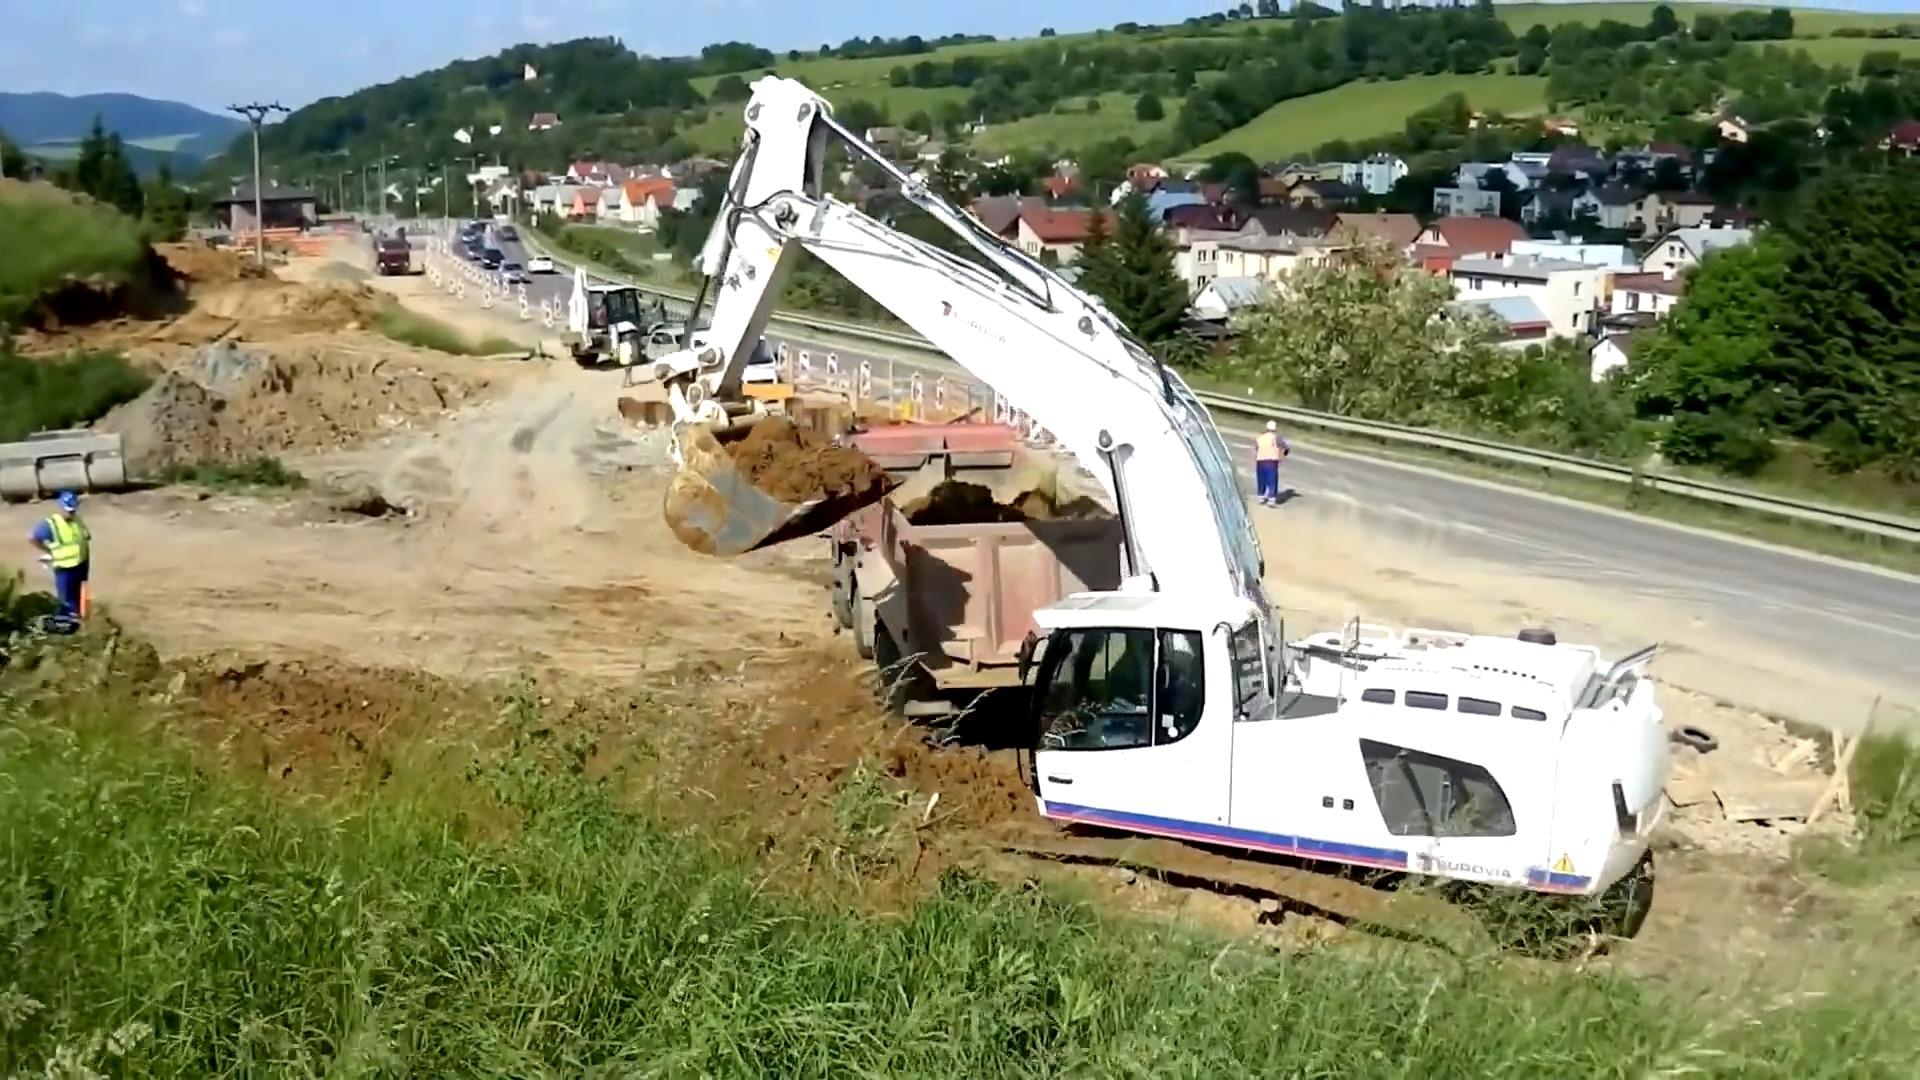

In [13]:
from PIL import Image
if res_img["ids"] and res_img["metadatas"][0]:
    test_path = res_img["metadatas"][0][0]["path"]
    display(Image.open(test_path))


In [9]:
# Qwen2.5-VL-3B-Instruct: generacja z kontekstem (PL)
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
processor = AutoProcessor.from_pretrained(model_id)
vlm = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    load_in_8bit=True # Load the model in 8-bit precision to save memory
)

# weź top-1 obraz i 1–2 fragmenty tekstowe z wcześniej policzonych res_img / res_txt
image_path = res_img["metadatas"][0][0]["path"] if res_img["ids"] else None
image_for_vlm = Image.open(image_path).convert("RGB") if image_path else None

context_snippets = []
if res_txt["ids"]:
    for doc in res_txt["documents"][0][:2]:
        context_snippets.append(doc[:400])

context_text = "Kontekst:\n" + "\n---\n".join(context_snippets) if context_snippets else "Brak kontekstu tekstowego."

prompt = (
    "Na podstawie kontekstu i obrazu odpowiedz po polsku. "
    "Najpierw w 1–2 zdaniach opisz obraz, potem streść wiedzę o kotach z kontekstu. "
    f"\n\n{context_text}\n"
)

if image_for_vlm:
    inputs = processor(text=prompt, images=[image_for_vlm], return_tensors="pt").to(vlm.device)
else:
    inputs = processor(text=prompt, return_tensors="pt").to(vlm.device)

out = vlm.generate(**inputs, max_new_tokens=220)
ans = processor.batch_decode(out, skip_special_tokens=True)[0]
print(ans)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:


# ====== Przygotowanie kontekstu do generacji ======
# Złóż krótki kontekst tekstowy + (opcjonalnie) jeden obraz dla VLM
context_snippets = []
image_for_vlm = None
for hid, meta, doc, dist in hits:
    if meta["type"] == "text":
        context_snippets.append(doc[:400])
    elif meta["type"] == "image" and image_for_vlm is None:
        try:
            image_for_vlm = Image.open(meta["path"]).convert("RGB")
        except Exception:
            image_for_vlm = None

context_text = "Kontekst (z retrieval):\n" + "\n---\n".join(context_snippets[:2]) if context_snippets else "Brak kontekstu tekstowego."

prompt = (
    "Na podstawie kontekstu i, jeśli dostępny, obrazu: \n"
    f"{context_text}\n\n"
    "Odpowiedz po polsku: streść wiedzę o kotach i opisz, co jest na obrazie."
)

# ====== Qwen2.5-VL-3B-Instruct (VLM) ======
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
processor = AutoProcessor.from_pretrained(model_id)
vlm = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto"
)

def generate_with_qwen_vl(prompt, image=None, max_new_tokens=200):
    if image is not None:
        inputs = processor(text=prompt, images=[image], return_tensors="pt").to(vlm.device)
    else:
        inputs = processor(text=prompt, return_tensors="pt").to(vlm.device)

    out = vlm.generate(**inputs, max_new_tokens=max_new_tokens)
    text = processor.batch_decode(out, skip_special_tokens=True)[0]
    return text

answer = generate_with_qwen_vl(prompt, image=image_for_vlm)
print("\n=== MODEL ANSWER ===\n")
print(answer)


Device: cuda



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


**Backup**


In [ ]:
# ====== Imports & setup ======
import os, glob, json, torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
from transformers import AutoProcessor, AutoModelForCausalLM
from pathlib import Path  # << PATCH: będziemy filtrować pliki po rozszerzeniach

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Ścieżki na dane
BASE = "/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG/data"
IMG_DIR = f"{BASE}/images/train"
TXT_DIR = f"{BASE}/texts"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(TXT_DIR, exist_ok=True)

# ====== Dane przykładowe (wrzuć swoje pliki do /content/data/images oraz /content/data/texts) ======
# jeśli nie masz obrazów, stworzymy jeden testowy "syntetyczny"
img_path = f"{IMG_DIR}/cat.jpg"
if not os.path.exists(img_path):
    img = Image.new("RGB", (512, 384), (230, 240, 255))
    d = ImageDraw.Draw(img)
    d.text((20, 20), "Photo of a white cat on green grass", fill=(10, 20, 60))
    img.save(img_path)

# jeśli nie masz tekstów, stworzymy dwa pliki
txt1 = f"{TXT_DIR}/faq_1.txt"
txt2 = f"{TXT_DIR}/faq_2.txt"
if not os.path.exists(txt1):
    with open(txt1, "w") as f:
        f.write("Kot domowy to gatunek ssaka drapieżnego z rodziny kotowatych. Lubi trawę i słońce.")
if not os.path.exists(txt2):
    with open(txt2, "w") as f:
        f.write("Qwen-VL to model Vision-Language, który potrafi łączyć obraz i tekst w odpowiedziach.")

# ====== Modele embeddingów ======
# Tekst: lekki, szybki
text_embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=DEVICE)
# Obraz: CLIP (wersja sentence-transformers; potrafi encode() na obrazach PIL)
image_embedder = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

def embed_texts(texts):
    vecs = text_embedder.encode(texts, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)
    return vecs

# ====== PATCH: bezpieczne wczytywanie obrazów + filtr rozszerzeń ======
IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".gif"}

def embed_images(paths):
    loaded_images = []
    kept_paths = []
    for p in paths:
        try:
            with Image.open(p) as im:
                loaded_images.append(im.convert("RGB").copy())
                kept_paths.append(p)
        except Exception as e:
            # Nie przerywaj — pomiń plik, który nie jest obrazem (np. _annotations.coco.json)
            print(f"[pomijam] {p}: {e}")

    if not loaded_images:
        dim = image_embedder.get_sentence_embedding_dimension()
        return np.zeros((0, dim)), []

    vecs = image_embedder.encode(
        loaded_images,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )
    return vecs, kept_paths
# ====== /PATCH ======


# ====== Budowa wektorówek (dwie kolekcje) ======
PERSIST_DIR = f"{BASE}/chroma"
client = chromadb.PersistentClient(path=PERSIST_DIR)

#client = chromadb.Client(Settings(anonymized_telemetry=False))
col_text  = client.get_or_create_collection(name="mmrag_text",  metadata={"hnsw:space": "cosine","dim":384,"embedder":"all-MiniLM-L6-v2"})
col_image = client.get_or_create_collection(name="mmrag_image", metadata={"hnsw:space": "cosine","dim":512,"embedder":"clip-ViT-B-32"})

# --- ŚCIEŻKI DANYCH (tuż po utworzeniu col_text/col_image) ---
IMG_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".bmp", ".gif"}
image_paths = [str(p) for p in Path(IMG_DIR).rglob("*") if p.suffix.lower() in IMG_EXTS]
text_paths  = [str(p) for p in Path(TXT_DIR).glob("*.txt")]

print(f"Znaleziono {len(image_paths)} obrazów i {len(text_paths)} tekstów")


# --- Dodaj TEXT ---
text_docs, text_ids = [], []
for p in text_paths:
    with open(p, "r", encoding="utf-8") as f:
        txt = f.read()
    text_docs.append(txt)
    text_ids.append(f"text::{os.path.basename(p)}")

txt_dim = text_embedder.get_sentence_embedding_dimension()
text_vecs = embed_texts(text_docs) if text_docs else np.zeros((0, txt_dim))
if len(text_docs):
    # Wyczyść duplikaty ID (idempotentny rerun)
    existing = {c for c in col_text.get(ids=text_ids)["ids"]} if text_ids else set()
    add_mask = [i for i, _id in enumerate(text_ids) if _id not in existing]
    if add_mask:
        col_text.add(
            ids=[text_ids[i] for i in add_mask],
            embeddings=[text_vecs[i].tolist() for i in add_mask],
            documents=[text_docs[i] for i in add_mask],
            metadatas=[{"type": "text", "path": text_paths[i]} for i in add_mask],
        )

# --- Dodaj IMAGE ---
img_vecs, kept_paths = embed_images(image_paths) if image_paths else (
    np.zeros((0, image_embedder.get_sentence_embedding_dimension())), []
)
if len(kept_paths):
    img_docs = [f"[IMAGE] {Path(p).name}" for p in kept_paths]
    img_ids  = [f"image::{Path(p).name}" for p in kept_paths]

    existing = {c for c in col_image.get(ids=img_ids)["ids"]} if img_ids else set()
    add_mask = [i for i, _id in enumerate(img_ids) if _id not in existing]
    if add_mask:
        col_image.add(
            ids=[img_ids[i] for i in add_mask],
            embeddings=[img_vecs[i].tolist() for i in add_mask],
            documents=[img_docs[i] for i in add_mask],
            metadatas=[{"type": "image", "path": kept_paths[i]} for i in add_mask],
        )

print("Indexed:", "texts:", col_text.count(), "| images:", col_image.count())




Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Znaleziono 523 obrazów i 2 tekstów
Indexed: texts: 2 | images: 523
